# North Atlantic O2
    - This script shows a workflow of estimating O2 anomalies usign ESM output and a few ML regressors
    - O2 is estimated as a function of T, S, Stratification, long, lat
    - Estimation methods include Multiple Linear Regression, Support Vector Machine, and Neural Network
    - hyperparameter tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw

### First prepare O2, T, S, stratification data

In [2]:
# access model output
model = 'GFDL-ESM4'
dir = '/glade/work/ito/dataset/model/'+model+'/'
dira= '/glade/work/acervania/dataset/model/'+model+'/'
ds0=xr.open_dataset(dir+'o2_'+model+'_196501-201412_subsampled.nc')
ds1=xr.open_dataset(dir+'so_'+model+'_196501-201412_subsampled.nc')
ds2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412_subsampled.nc')
ds3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412_subsampled.nc')

In [3]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [4]:
# select depth level
zlev=500

In [5]:
# get coordinates
x=ds0.lon.to_numpy()
y=ds0.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [6]:
# extract data in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)
o2 = ds0.o2.sel(depth=zlev)*1e3
so = ds1.so.sel(depth=zlev)
to = ds2.thetao.sel(depth=zlev)
dr = ds3.Nsquared.sel(depth=zlev)
mld= ds3.MLD.sel(depth=zlev)

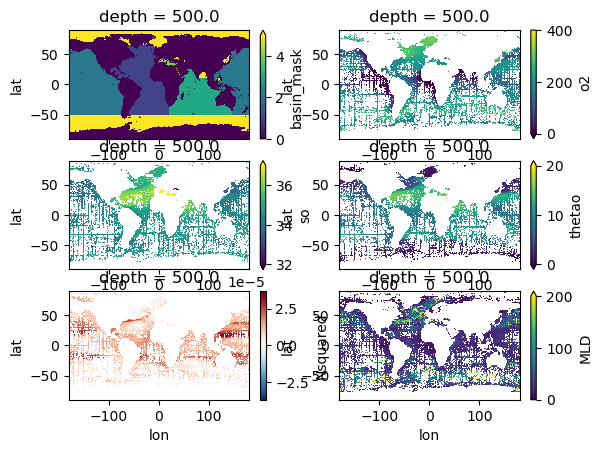

In [7]:
# take a look at the data
fig,ax=plt.subplots(3,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
o2.mean('time').plot(ax=ax[0,1],vmin=0,vmax=400,label='O2')
so.mean('time').plot(ax=ax[1,0],vmin=32,vmax=37,label='S')
to.mean('time').plot(ax=ax[1,1],vmin=0,vmax=20,label='T')
dr.mean('time').plot(ax=ax[2,0],label='N2')
mld.mean('time').plot(ax=ax[2,1],vmin=0,vmax=200,label='MLD')

In [8]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

### Prepare monthly climatology data so we can calculate anomalies

In [9]:
# monthly climatology
#dc0=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_all_o00_01.nc',decode_times=False)
#dc1=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_s00_01.nc',decode_times=False)
#dc2=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_t00_01.nc',decode_times=False)
dc0=xr.open_dataset(dir+'o2_'+model+'_196501-201412.nc')
dc1=xr.open_dataset(dir+'so_'+model+'_196501-201412.nc')
dc2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412.nc')
dc3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412.nc')

In [10]:
# extract 500m climatology
o2c=dc0.o2.sel(depth=zlev).groupby('time.month').mean('time')*1e3
soc=dc1.so.sel(depth=zlev).groupby('time.month').mean('time')
toc=dc2.thetao.sel(depth=zlev).groupby('time.month').mean('time')
drdzc=dc3.Nsquared.sel(depth=zlev).groupby('time.month').mean('time')
mldc=dc3.MLD.sel(depth=zlev).groupby('time.month').mean('time')

In [11]:
# subtract climatology from the discrete data to define anomalies
doa=o2.groupby('time.month')-o2c
dsa=so.groupby('time.month')-soc
dta=to.groupby('time.month')-toc
dra=dr.groupby('time.month')-drdzc
dha=mld.groupby('time.month')-mldc
#
# make numpy array
doa = doa.to_numpy()
dsa = dsa.to_numpy()
dta = dta.to_numpy()
dra = dra.to_numpy()
dha = dha.to_numpy()
#
# prepare lat lon data
xx1 = np.tile(xx,[600,1,1])
yy1 = np.tile(yy,[600,1,1])

In [12]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)
dha=np.where((ma==1)&(yy>0),dha,np.nan)

### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array

In [13]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()

In [14]:
# remove nan
dd = doa0 + dsa0 + dta0 + dra0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

20329


In [15]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

## ML

### First split the data into training and test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1,test_size=0.15)

In [17]:
a=y_train.size
b=y_test.size
a/(a+b)

0.8499680259727483

### MLR estimator (MLregr)

In [18]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [19]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

0.43605928125160265
correlation =  0.6607687084976842
RMSE =  6.166494113980145


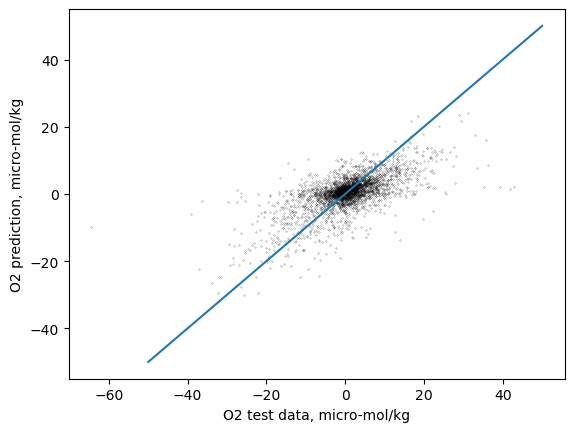

In [20]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(MLregr, X_test, y_test, cv=5)
scores

array([0.34934533, 0.44118428, 0.4370539 , 0.48588392, 0.45977333])

### Support Vector Machine estimator (SVregr)

In [22]:
##
## Support Vector Regression
##
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV

In [23]:
clf = svm.SVR()
parameters = {'C':[1, 3, 6, 9],'epsilon':[.1,.2,.5]}
SVregr = GridSearchCV(clf, parameters)
SVregr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 3, 6, 9], 'epsilon': [0.1, 0.2, 0.5]})

In [24]:
SVregr.cv_results_

{'mean_fit_time': array([10.97595863,  8.7123426 ,  4.20904813, 12.14043593,  9.57546072,
         4.62894664, 13.65979657, 10.82015891,  5.16850605, 15.32195334,
        12.11069689,  5.71715794]),
 'std_fit_time': array([0.05485328, 0.05068813, 0.02733156, 0.07035531, 0.06370411,
        0.06512682, 0.07078455, 0.03965049, 0.06791231, 0.09234102,
        0.14901998, 0.0837733 ]),
 'mean_score_time': array([3.66785893, 2.93076906, 1.43658242, 3.65015998, 2.89368949,
        1.40395665, 3.63156266, 2.8731359 , 1.38309941, 3.62098503,
        2.86508389, 1.37218752]),
 'std_score_time': array([0.00455496, 0.01817965, 0.00742623, 0.00894798, 0.01730266,
        0.00486143, 0.00582854, 0.01343251, 0.00696624, 0.01355456,
        0.0118011 , 0.00791741]),
 'param_C': masked_array(data=[1, 1, 1, 3, 3, 3, 6, 6, 6, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=ob

In [25]:
# use the best fit parameter
out=SVregr.predict(X_test)

correlation =  0.8223695682904519
RMSE =  4.679930077480588


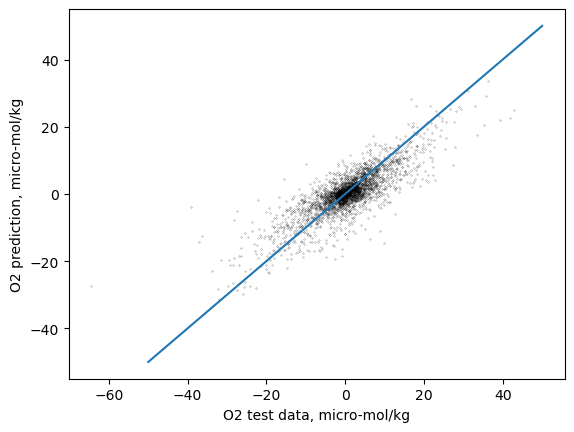

In [26]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_SV=temp[0,1]
print('correlation = ',Rval_SV)
RMSE_SV=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_SV)

### shallow Neural Network estimator (SNNregr)

In [27]:
## NN
from sklearn.neural_network import MLPRegressor

In [28]:
# shallow NN
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[6,6],[10,6],[40,6]],'alpha':[.0001,.001,.01]}
sNNregr = GridSearchCV(clf, parameters)

In [29]:
sNNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[6, 6], [10, 6], [40, 6]]})

In [30]:
out = sNNregr.predict(X_test)
sNNregr.cv_results_

{'mean_fit_time': array([2.61407328, 2.51043921, 1.8549408 , 2.3365602 , 2.42954817,
        2.56367002, 2.21946664, 1.96851778, 2.18021688]),
 'std_fit_time': array([0.70051599, 0.29479358, 0.27787326, 0.58953391, 0.32882313,
        0.36690905, 0.52785699, 0.19538741, 0.50880885]),
 'mean_score_time': array([0.00054083, 0.00054297, 0.00061698, 0.00053358, 0.0005415 ,
        0.00064263, 0.00052872, 0.00053897, 0.00061617]),
 'std_score_time': array([1.79068702e-05, 4.32741215e-06, 4.13063199e-06, 3.04579152e-06,
        1.39347450e-06, 4.77884097e-05, 1.31972814e-06, 1.63521082e-06,
        8.13227565e-06]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([6, 6]), list([10, 6]), list([40, 6]),
               

correlation =  0.8409196092051727
RMSE =  4.463843841640769


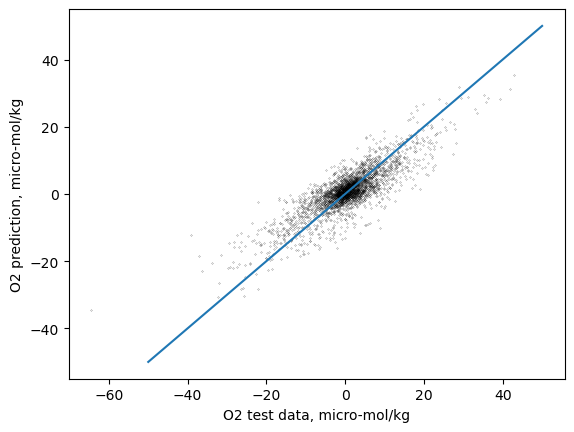

In [31]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_sNN=temp[0,1]
print('correlation = ',Rval_sNN)
RMSE_sNN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_sNN)

### deep Neural Network estimator (NNregr)

In [32]:
# deep NN 30-30-30-5
dNNregr = MLPRegressor(max_iter=1000).fit(X_train, y_train)

In [33]:
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[6,6,6,6],[10,10,10,6],[40,30,20,6]],'alpha':[.0001,.001,.01]}
dNNregr = GridSearchCV(clf, parameters)

In [34]:
dNNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[6, 6, 6, 6], [10, 10, 10, 6],
                                                [40, 30, 20, 6]]})

In [35]:
out = dNNregr.predict(X_test)
dNNregr.cv_results_

{'mean_fit_time': array([2.92096004, 2.6652442 , 2.9654943 , 2.49269981, 2.8294807 ,
        3.20700846, 3.15745854, 2.94954576, 2.58913026]),
 'std_fit_time': array([0.75491472, 0.27867482, 0.44316283, 0.46562249, 0.68151968,
        0.51117877, 0.38621703, 0.58525216, 0.69107759]),
 'mean_score_time': array([0.00059738, 0.00063205, 0.00081263, 0.00059185, 0.0006536 ,
        0.00082688, 0.00058823, 0.00062671, 0.00081401]),
 'std_score_time': array([1.45662630e-05, 9.25481840e-06, 2.37271410e-06, 5.56205558e-06,
        5.12604603e-05, 2.97079117e-05, 1.84308511e-06, 2.44352874e-06,
        4.28464124e-06]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([6, 6, 6, 6]), list([10, 10, 10, 6]),
                

correlation =  0.8857861434935155
RMSE =  3.825837195794247


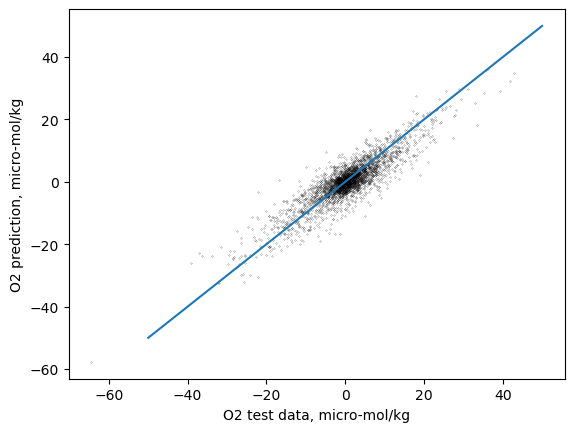

In [36]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

## mapping O2 for a particular year and month

In [37]:
year = 1979
month = 6
it = month+(year-1965)*12-1
print('time index = '+str(it))

time index = 173


In [38]:
# prepare TS input, prepare O2 test data
soa=dc1.so.isel(time=it).sel(depth=zlev)-soc[month-1,:,:]
toa=dc2.thetao.isel(time=it).sel(depth=zlev)-toc[month-1,:,:]
o2a=dc0.o2.isel(time=it).sel(depth=zlev)*1e3-o2c[month-1,:,:]
dra=dc3.Nsquared.isel(time=it).sel(depth=zlev)-drdzc[month-1,:,:]
dha=dc3.MLD.isel(time=it).sel(depth=zlev)-mldc[month-1,:,:]
zo=dc0.depth.to_numpy()

In [39]:
# take a look at the data
#fig,ax=plt.subplots(2,2)
#ax[0,0].pcolormesh(xx,yy,toa,cmap='RdBu_r',vmin=-3,vmax=3)
#ax[0,1].pcolormesh(xx,yy,soa,cmap='RdBu_r',vmin=-.3,vmax=.3)
#ax[1,0].pcolormesh(xx,yy,dra,cmap='RdBu_r',vmin=-.003,vmax=.003)
#ax[1,1].pcolormesh(xx,yy,o2a,cmap='RdBu_r',vmin=-30,vmax=30)

In [40]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),o2a,np.nan)
dsa=np.where((ma==1)&(yy>0),soa,np.nan)
dta=np.where((ma==1)&(yy>0),toa,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)
dha=np.where((ma==1)&(yy>0),dha,np.nan)

In [41]:
# take a look at the data
#fig,ax=plt.subplots(2,2)
#ax[0,0].pcolormesh(xx,yy,dta,cmap='RdBu_r',vmin=-3,vmax=3)
#ax[0,1].pcolormesh(xx,yy,dsa,cmap='RdBu_r',vmin=-.3,vmax=.3)
#ax[1,0].pcolormesh(xx,yy,dra,cmap='RdBu_r',vmin=-.003,vmax=.003)
#ax[1,1].pcolormesh(xx,yy,doa,cmap='RdBu_r',vmin=-30,vmax=30)

In [42]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx.flatten()
yy0  = yy.flatten()
xi0  = xxi.flatten()
yi0  = yyi.flatten()

In [43]:
# remove nan
dd = dsa0 + dta0 + dra0 + doa0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
xi1=xi0[np.isnan(dd)==False]
yi1=yi0[np.isnan(dd)==False]
Nsample = np.size(dsa1)
print(Nsample)

3405


In [44]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1])
Xa = (X.T - Xm)/Xstd

In [45]:
# projection
out = dNNregr.predict(Xa)
outMLR = MLregr.predict(Xa)
outSVR = SVregr.predict(Xa)
outSNN=sNNregr.predict(Xa)

In [46]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=out[n]
o2estNN = temp*ystd + ym
RMSE_DNN=np.sqrt(np.mean((out*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,out)
R_DNN=temp[0,1]

In [47]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outMLR[n]
o2estMLR = temp*ystd + ym
RMSE_MLR=np.sqrt(np.mean((outMLR*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outMLR)
R_MLR=temp[0,1]

In [48]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outSVR[n]
o2estSVR = temp*ystd + ym
RMSE_SVR=np.sqrt(np.mean((outSVR*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outSVR)
R_SVR=temp[0,1]

In [49]:
temp = np.nan*np.zeros((180,360))
for n in range(Nsample):
    temp[yi1[n],xi1[n]]=outSNN[n]
o2estSNN = temp*ystd + ym
RMSE_SNN=np.sqrt(np.mean((outSNN*ystd+ym-doa1)**2))
temp=np.corrcoef(doa1,outSNN)
R_NN=temp[0,1]

Text(0.5, 1.0, 'RMSE')

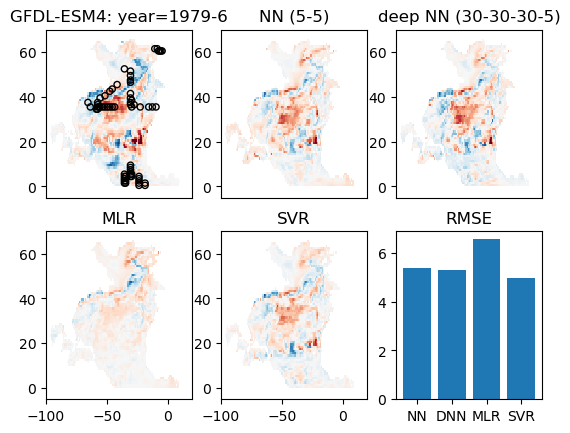

In [50]:
dat = dsd.isel(time=it).sel(depth=zlev)

fig,ax=plt.subplots(2,3)
ax[0,0].pcolormesh(xx,yy,doa,vmin=-30,vmax=30,cmap='RdBu_r')
dpos=dat.mask.to_numpy()
xxx=np.where((ma==1)&(yy>0),xx,np.nan)
yyy=np.where((ma==1)&(yy>0),yy,np.nan)
xpos=xxx[dpos==1]
ypos=yyy[dpos==1]
ax[0,0].scatter(xpos, ypos, s=20, facecolors='none', edgecolors='k')
ax[0,0].set_xlim(-100,20)
ax[0,0].set_ylim(-5,70)
ax[0,0].set_title(model+': year='+str(year)+'-'+str(month))
ax[0,0].set_xticks([])
#
ax[0,1].pcolormesh(xx,yy,o2estSNN,vmin=-30,vmax=30,cmap='RdBu_r')
ax[0,1].set_xlim(-100,20)
ax[0,1].set_ylim(-5,70)
ax[0,1].set_title('NN (5-5)')
ax[0,1].set_xticks([])
#
ax[0,2].pcolormesh(xx,yy,o2estNN,vmin=-30,vmax=30,cmap='RdBu_r')
ax[0,2].set_xlim(-100,20)
ax[0,2].set_ylim(-5,70)
ax[0,2].set_title('deep NN (30-30-30-5)')
ax[0,2].set_xticks([])
#
#ax[0,2].pcolormesh(xx,yy,o2est-doa,vmin=-30,vmax=30,cmap='RdBu_r')
#ax[0,2].set_xlim(-100,20)
#ax[0,2].set_ylim(-5,70)
#ax[0,2].set_title('bias')
#
ax[1,0].pcolormesh(xx,yy,o2estMLR,vmin=-30,vmax=30,cmap='RdBu_r')
ax[1,0].set_xlim(-100,20)
ax[1,0].set_ylim(-5,70)
ax[1,0].set_title('MLR')
#
ax[1,1].pcolormesh(xx,yy,o2estSVR,vmin=-30,vmax=30,cmap='RdBu_r')
ax[1,1].set_xlim(-100,20)
ax[1,1].set_ylim(-5,70)
ax[1,1].set_title('SVR')
#
ax[1,2].bar(['NN','DNN','MLR','SVR'],[RMSE_SNN,RMSE_DNN,RMSE_MLR,RMSE_SVR])
ax[1,2].set_title('RMSE')
#ax[1,2].bar(['NN','DNN','MLR','SVR'],[R_NN,R_DNN,R_MLR,R_SVR])